進入Monte Carlo的範例之後，我們知道，MC的一個主要就是會從跟環境的互動中取得經驗，再利用這個經驗來優化agent，所以我們就試著從架構環境開始，範例上會參考[dennybritz](https://github.com/dennybritz/reinforcement-learning/tree/master/MC)，再加上自己的理解說明。

Chapter 5的範例主要是21點，這遊戲規則大家都知道，不過我還是把書本中所整理的部份資訊也在這邊提供，方便對照。

Example 5.1: Blackjack 
以21點為例，雖然大家應該都知道怎麼玩，不過還是說明一下規則(假設每一個玩家跟庄家都是獨立在玩)：
1. 牌不能超過21
2. J、Q、K都是10
3. A可以當1也可以當11
4. 開場每人發兩張牌，各露一張牌、蓋一張牌
5. 如果玩家直接21點，那就是天胡，除非另一方也是天胡，不然就是直接贏了
6. 玩家不是天胡的情況下可以一直要牌，但牌點不能超過21
7. 換庄家要牌，直到大於等於17的時候停牌，如果庄家爆牌那就玩家贏

21點是一種典形的episodic finite MDP。每一張牌局都是一個episode，贏牌reward +1，和局 +0，輸了 -1。遊戲中的reward皆為0，並且這邊我們不計算discount，也就是$\gamma=1$，因此最終的reward也是returns。

玩家的actions有兩個：
1. 要牌
2. 停牌

state則是取決於玩家與庄家顯示的牌。我們假設這是一個無限牌堆(也就是抽完放回)，因此不需要記憶那些牌已經被抽。如果玩家有A，那不會爆的情況下可以把A視為11，我們稱這個A為usable。這時候通常將A視為11，如果視為1的話，那牌最多小於等於11(1+10)，這時候不用選擇，可以直接要牌，抽牌隨便抽都大於11，一定更好。因此，玩家會依據三個變數來做出決定：玩家當前的總合(12-21)，庄家顯示的牌組(A-10)，以及玩家是否有usable A。如此，總共有200個states(10x10x2?)。

考慮一種policy，當玩家的牌點總合為20或21的時候就停牌，不然就要牌。為了能夠利用MC(後續以MC表示Monte Carlo method)來找出這個policy的state-value function，我們用這個policy來模擬很多場21點的賽局，然後平均每一個state的returns。

最終我們得到如Figure 5.1(下圖)state-value function的推估結果。左上圖可以看的出來，有usable A的情況是較不穩定的，不過不管是那一種情況，在500000局之後，state-value function都得到很好的近似。

![](https://i.imgur.com/klThjUj.png)

參考的來源作者主要是利用openai所open的gym來實作環境，這部份倒是可以看個人

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

%matplotlib inline

下面先設置一些類別需要的函數，這也是看個人的習慣

action space，要牌(0)、停牌(1)

In [2]:
action_space = [0, 1] 

牌組，1~10、J、Q、K

In [3]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] 

設置抽牌的函數

In [4]:
def draw_card(deck):
    """隨機從牌組中抽一張牌"""
    return np.random.choice(deck)

In [5]:
draw_card(deck)

4

In [6]:
def draw_hand(deck):
    """回傳一個牌組，也就是兩張牌"""
    return [draw_card(deck), draw_card(deck)]

In [7]:
draw_hand(deck)

[3, 10]

In [8]:
def usable_ace(hand):
    """判斷牌組內是否有用ace
    
    只要牌組內有ace(1)，然後牌組的總和小於等於21，就視為將ace做為11使用
    """
    return 1 in hand and sum(hand) + 10 <= 21

In [9]:
hand = draw_hand(deck)
print(hand, usable_ace(hand))

[2, 8] False


In [10]:
def sum_hand(hand):
    """加總牌組，過程中會判斷是否有將ace做為11使用"""
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

In [11]:
sum_hand(hand)

10

In [12]:
def is_bust(hand):
    """判斷牌組是否已經爆牌"""
    return sum(hand) > 21

In [13]:
is_bust(hand)

False

In [14]:
def score(hand):  
    """還不是很清楚設置這一個函數的用意
    
    這個函數看起來就是以牌組的總和為值回傳，前提是沒有爆牌
    """
    return 0 if is_bust(hand) else sum_hand(hand)

In [15]:
score(hand)

10

下面開始設置環境

In [16]:
class BlackjackEnv():
    """21點的模擬環境，相關書本中的內容可以參考上面說明"""
    def __init__(self, action_space, deck):
        """
        action_space: 要牌、停牌
        deck: 牌組
        """
        self.action_space = action_space
        self.deck = deck
        self.action_nums = len(self.action_space)        
        
        # 初始的時候先重置牌局
        self.reset()
        
    def get_observation(self):
        """回傳當前的觀察狀態
        
        依課本說明，回傳的為[玩家的牌組總合, 庄家的1張牌, 是否將ace視為11]
        """
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))
    
    def reset(self):
        """賽局重置
        
        重置賽局的時候我們會重新發給玩家跟庄家牌組，
        只要玩家的牌組是小於12，那就再給牌，補到12
        
        return:
            observation，[玩家的牌組總合, 庄家的1張牌, 是否將ace視為11]
        """
        self.dealer = draw_hand(self.deck)
        self.player = draw_hand(self.deck)
        
        # 玩家的牌如果小於12就直接補牌
        while sum_hand(self.player) < 12:
            self.player.append(draw_card(self.deck))
        
        return self.get_observation()
        
    def step(self, action):
        """與環境的互動
        
        每個time step根據觀測到的狀態來決定一個action，
        在執行一個action之後環境就會產生新的狀態，並計算得到的reward
        其中reward贏牌+1、和牌+0、輸牌-1
        
        如果要牌，就發一張牌，然後判斷是不是有爆，
        如果停牌，那就換庄家補牌到17以上，庄家爆牌就玩家贏
        不然就是兩個比較大小決定誰贏
        
        return:
            next observation、reward、done
        """
        assert action in self.action_space
        
        # 要牌
        if action:
            self.player.append(draw_card(self.deck))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else: # 停牌
            done = True               
            
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.deck))            
            
            if is_bust(self.dealer):
                reward = 1
            elif sum_hand(self.player) == sum_hand(self.dealer):
                reward = 0
            elif sum_hand(self.player) < sum_hand(self.dealer): 
                reward = -1
            elif sum_hand(self.player) > sum_hand(self.dealer):
                reward = 1
        
        return self.get_observation(), reward, done
            
        
            
            

new一個環境

In [17]:
env = BlackjackEnv(action_space, deck)

In [18]:
env.get_observation()

(14, 9, False)

環境設置好了，我們先來處理Example 5.1，這個範例很簡單，單純的考慮state，所以這是一個prediction的問題

首先設置policy，根據書中所說，總之20點以前就是一直要牌

In [19]:
def book_policy(observation):
    """根據所觀測到的state來決定action
    observation: 從env中得到的state
    
    根據書中所寫，20點之前都會一直要牌
    """
    player_sum, _, _ = observation
    return 0 if player_sum >= 20 else 1

In [20]:
_observation = (15, 4, False)

In [21]:
book_policy(_observation) == 1

True

In [22]:
def example5_1(episodes, env, policy, discount_factor=1.0):
    """根據課本中5.1的範例設置的Monte Carlo
    
    episodes: 預計執行的賽局次數
    env: 模擬的環境
    policy: agent的policy
    discount_factory: 折扣因子，範例中為1
    
    這邊單純的考慮state，我們會根據Monte Carlo的特性，利用sample來模擬很多的賽局，
    再根據賽局的結果來優化value function
    
    我們會設置兩個defaultdict來跟蹤每一個state的reward總和與出現的次數，
    接著在每一個episode的過程中記錄這個episode的trajectory
    
    return V: value function，
    """
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    # V，就是value function
    V = defaultdict(float)
    
    for epi in range(1, episodes + 1):
        trajectory = []
        # 每個episode的開場都會重新開局這個賽局
        state = env.reset()
        # 這邊的作法是假設你在100次互動內會完成這場賽局
        # 雖然實務上很難到100次互動啦，總之爆了就結束這樣
        for i in range(100):
            # 根據書本中的policy取得action
            action = policy(state)
            # 取得與環境互動的結果
            next_state, reward, done = env.step(action)
            # 記錄軌跡
            trajectory.append((state, action, reward))
            # 如果牌局結束那停止迭代
            if done:
                break
            state = next_state
        
        # 現在我們有一個episode，也就是一場賽局的軌跡
        # 利用這個trajectory來計算value function
        # 先取出所有出現過的state，可以利用set的特性來消除重覆性資料
        state_in_episode = set([tuple(x[0]) for x in trajectory])
        for s in state_in_episode:
            # 我們採用的是first visit
            # 找出這個state最早出現在這個episode的什麼地方
            # 就從這邊開始計算這個state的value
            state_first_idx = next(i for i, x in enumerate(trajectory) if x[0] == s)            
            # 如果忘了這個公式，可以回頭看Chapter 3
            # G: expected return, x[2]: reward
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(trajectory[state_first_idx: ])])
            # 把這個state得到的expected return加起來
            returns_sum[s] += G
            # 加總這個state出現的次數
            returns_count[s] += 1
            V[s] = returns_sum[s] / returns_count[s]
        
    return V
            

來試玩10局吧

In [23]:
env = BlackjackEnv(action_space, deck)
V_10 = example5_1(10, env, book_policy)

課本中是以玩10,000與500,000來做比較，我們也試一下

In [24]:
%%time
env = BlackjackEnv(action_space, deck)
V_10k = example5_1(10000, env, book_policy)

CPU times: user 869 ms, sys: 517 µs, total: 869 ms
Wall time: 868 ms


In [25]:
%%time
env = BlackjackEnv(action_space, deck)
V_500k = example5_1(500000, env, book_policy)

CPU times: user 41.6 s, sys: 4.77 ms, total: 41.6 s
Wall time: 41.6 s


In [26]:
V_10

defaultdict(float,
            {(13, 5, False): -1.0,
             (16, 5, False): -1.0,
             (14, 7, True): 1.0,
             (20, 7, True): 1.0,
             (18, 10, False): -1.0,
             (20, 6, False): 1.0,
             (20, 9, False): 1.0,
             (18, 1, False): -1.0,
             (17, 10, False): -1.0,
             (12, 10, False): -1.0,
             (20, 10, False): 0.0,
             (18, 4, False): -1.0})

下面我們看一下dennybritz所寫的繪圖函數，主要使用的是3D的模組

* [田野光的技術小站_np.meshgrid](https://wangyeming.github.io/2018/11/12/numpy-meshgrid/)
* [numpy.apply_along_axis](https://numpy.org/doc/stable/reference/generated/numpy.apply_along_axis.html)

這邊稍微的呈現一些執行資料的結果比較容易理解下面的函數處理

In [27]:
min_x, max_x, min_y, max_y = 12, 21, 1, 10
x_range = np.arange(min_x, max_x + 1)
y_range = np.arange(min_y, max_y + 1)
print(x_range, y_range)

[12 13 14 15 16 17 18 19 20 21] [ 1  2  3  4  5  6  7  8  9 10]


In [28]:
# 產生座標矩陣
X, Y = np.meshgrid(x_range, y_range)
X, Y

(array([[12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]),
 array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [29]:
np.dstack([X, Y])[0], np.dstack([X, Y])[0][0], np.dstack([X, Y])[0][0][0], np.dstack([X, Y])[0][0][1]

(array([[12,  1],
        [13,  1],
        [14,  1],
        [15,  1],
        [16,  1],
        [17,  1],
        [18,  1],
        [19,  1],
        [20,  1],
        [21,  1]]), array([12,  1]), 12, 1)

In [30]:
def np_func(d):
    global V_10
    # 這邊的d[0], d[1]就是上面那個np.dstack之後得到的array的值
    # 見上面執行結果的最後兩個
    # V_10本身是一個defaultdict(float)物件，因此有值就有值，沒有值就是預設值，也就是0
    return V_10[d[0], d[1], False]

In [31]:
np.apply_along_axis(np_func, 2, np.dstack([X, Y]))

array([[ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.]])

下面的lambda處理等價於上面的處理，其實就是把堆起來的座標做為輸入去查詢相對座標的值

In [32]:
np.apply_along_axis(lambda _: V_10[(_[0], _[1], False)], 2, np.dstack([X, Y]))

array([[ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.]])

In [33]:
def plot_value_function(V, title="Value Function"):
    """繪製value function
    
    我們的圖表會有兩張圖與三個維度：
        兩張圖分別為有沒有把ace視為11使用
        三個維度為：
        (1)玩家的牌組(因為玩家的牌預設已經是大於等於12以上，因此會從12開始)
        (2)庄家亮出的牌
        (3)該state的value
    """
    # 這邊整理的是玩家的牌與庄家的牌最小值與最大值
    # 不過個人認為，因為範例上一開始已經限定值域了，因此應該可以直接硬性設定即可        
#     min_x = min(k[0] for k in V.keys())
#     max_x = max(k[0] for k in V.keys())
#     min_y = min(k[1] for k in V.keys())
#     max_y = max(k[1] for k in V.keys())
    min_x, max_x, min_y, max_y = 12, 21, 1, 10
        
    x_range = np.arange(min_x, max_x + 1)    
    y_range = np.arange(min_y, max_y + 1)
    # np.meshgrid是一個生成座標矩陣的函數    
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    # np.apply_along_axis就是一種人如其名的函數，針對某一個軸向執行某一個函數
    # 主要是取得把ace視為11與不視為11的資料
    # 回傳的value function是一個defaultdict(float)的資料
    # 因此利用座標去詢條件，舉例來說，V[0, 0, False]，有值有值，沒有值就是0
    # 如果還不是很清楚可以看上面的分段執行的結果就不難理解這邊處理的手法
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title):
        # 定義figure的大小
        fig = plt.figure(figsize=(20, 10))
        # 增加一個3d的子圖表
        ax = fig.add_subplot(111, projection='3d')
        # rstride、cstride: 座標軸的間距大小
        # vmin, vmax: value的最大最小值，
        # cmap: 色彩配置
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        # 視角的設置
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

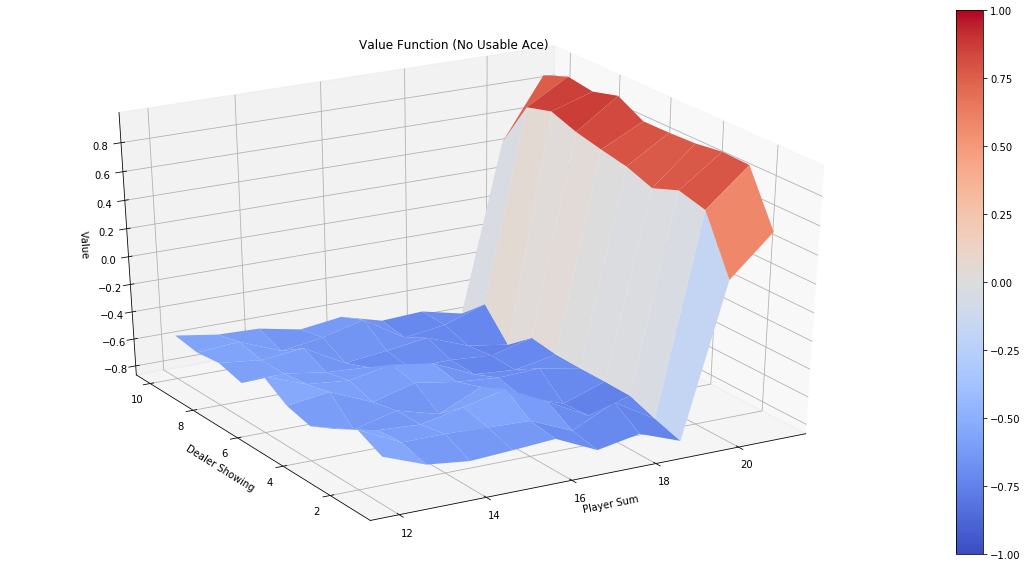

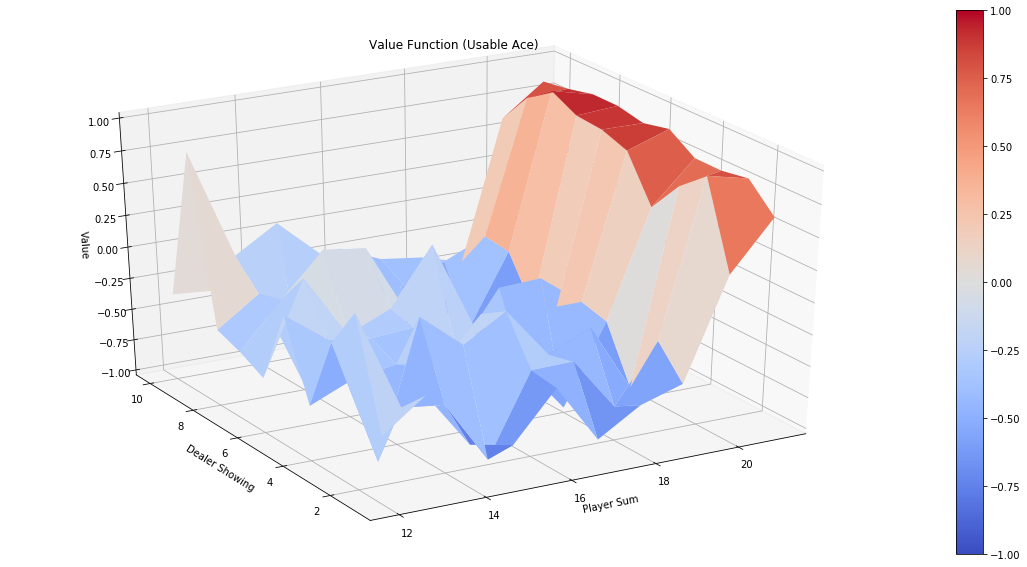

In [34]:
plot_value_function(V_10k)

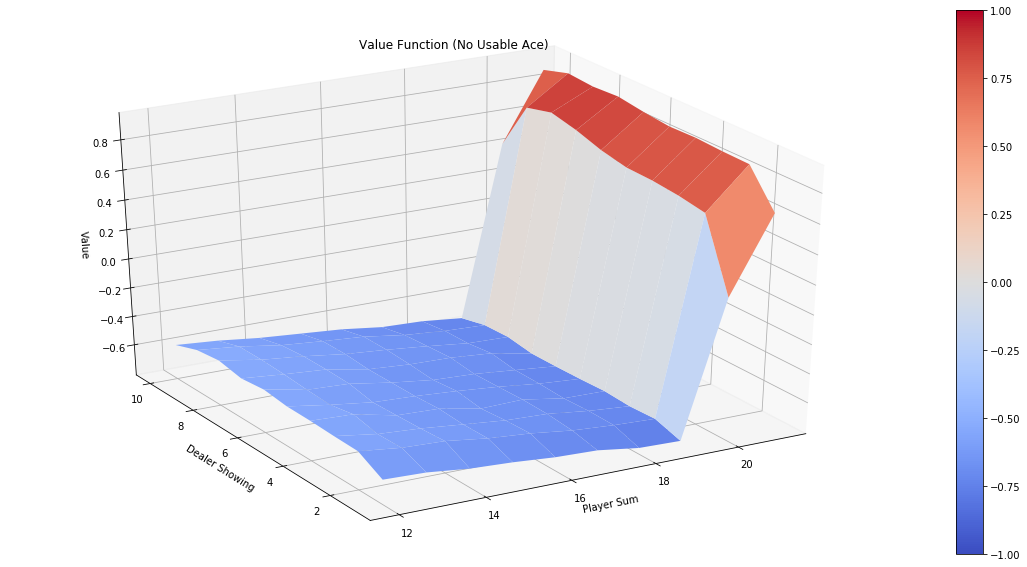

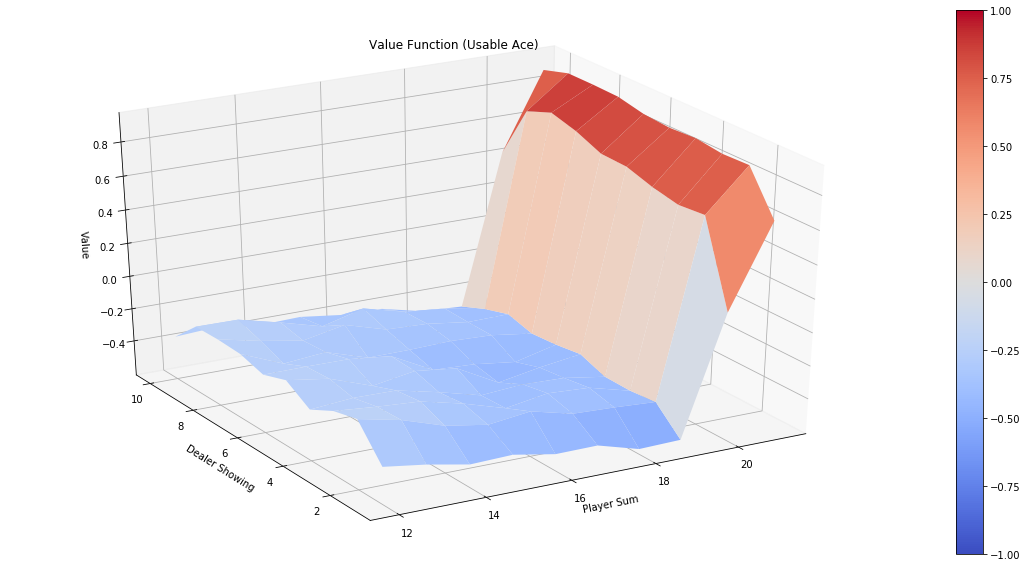

In [35]:
plot_value_function(V_500k)

得到的結果來看，跟書本上長的還蠻像的，感覺不錯